## RLDMUU 2025
#### Q-learning and SARSA
jakub.tluczek@unine.ch

Today we are going to implement two fundamental temporal difference algorithms - Q-learning and SARSA. Both of these algorithms choose action based on $Q(s,a)$ function, but update it in a diffetent manner. Q-learning update goes as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_a Q(s',a) - Q(s,a)\right] $$

While SARSA updates its $Q(s,a)$ in a following way:

$$ Q(s,a) \leftarrow \alpha \left[ r + \gamma Q(s', a') - Q(s,a) \right] $$

where $\alpha$ is a learning rate and $\gamma$ is a discount factor.

Difference between these two arises when computing the discounted value of $Q$ for next state. As $Q : S \times A \rightarrow \mathbb{R}$, we need to pick the next action. We can do it either by maximizing over all actions in an off-line fashion (Q-Learning) or assume that the next action will be picked using the same poicy $\pi$ we are currently following. 

Your task is to program both Q-Learning and SARSA from scratch:

In [1]:
import numpy as np

In [2]:
class QLearning:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon):
        self.n_states = n_states 
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon

        self.Q = np.zeros((n_states, n_actions))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            max_idxs = np.argwhere(self.Q[state,:] == np.amax(self.Q[state,:])).flatten()
            return np.random.choice(max_idxs)

    def update(self, state, action, reward, next_state):
        self.Q[state, action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action])

    def reset(self):
        self.Q = np.zeros((self.n_states, self.n_actions))

In [3]:
class SARSA:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon):
        self.n_states = n_states 
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon

        self.Q = np.zeros((n_states, n_actions))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            max_idxs = np.argwhere(self.Q[state,:] == np.amax(self.Q[state,:])).flatten()
            return np.random.choice(max_idxs)

    def update(self, state, action, reward, next_state):
        self.Q[state, action] += self.alpha * (reward + self.gamma * self.Q[next_state, self.act(next_state)] - self.Q[state, action])

    def reset(self):
        self.Q = np.zeros((self.n_states, self.n_actions))

### Gymnasium

Now let's introduce a python framework that you are going to work with over the course of this semester, namely `gymnasium`, which is the successor of OpenAI `gym`. Let's go through the basic functionality of `gymnasium` based environments. First, let's import a Frozen Lake environment:

In [4]:
import gymnasium as gym

env = gym.make('FrozenLake-v1')

Before the first use, and after each episode we have to reset an environment. `reset()` function returns the state represenation and an additional dictionary `info`, if we ever wanted to collect some additional data about the environment. For now we won't take it into consideration.

In [5]:
state, info = env.reset()
# useful for checking if the environment terminated
done = False

*Hint*: In order to create Q tables we have to know the size of the state and action space. We can check it with:

In [6]:
print(f"Observation space size: {env.observation_space}")
print(f"Action space size: {env.action_space}")

Observation space size: Discrete(16)
Action space size: Discrete(4)


Now let's act on the environment and observe the results (we sample the action for now). For this reason we provide an action to the `step` method and observe the following:

- `next_state` to which we transition
- `reward` received
- `done` signal, indicating if the environment terminated
- `truncated` signal, indicating whether a timeout or other external constraint had been reached
- `info` dict with supplementary information

In [7]:
action = env.action_space.sample()

next_state, reward, done, truncated, info = env.step(action)

Your task is to perform both Q-Learning and SARSA to learn the optimal policy for an agent acting in an environment. After you're done, plot the rewards.

In [32]:
N_EPISODES = 10000
N_ITER = 100

ALPHA = 1e-2
GAMMA = .95
EPSILON = .1


state, info = env.reset()
done = False 

algo = QLearning(n_states=env.observation_space.n, n_actions=env.action_space.n, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON)

nsteps = np.ones(N_EPISODES) * N_ITER

mean_episode_rewards = np.zeros(N_EPISODES)

for e in range(N_EPISODES):
    for i in range(N_ITER):
        action = algo.act(state)

        next_state, reward, done, truncated, info = env.step(action)

        algo.update(state, action, reward, next_state)

        if done or truncated:
            state, info = env.reset()
            done = False
            truncated = False
            if reward == 1:
                nsteps[e] = i 
                mean_episode_rewards[e] = 1 / i
            break

        state = next_state

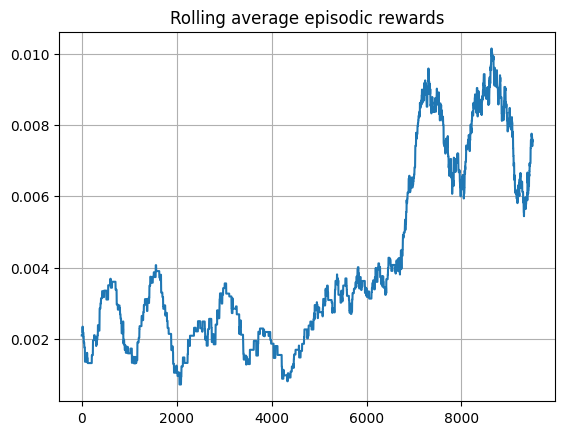

In [33]:
from matplotlib import pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(mean_episode_rewards, 500))
plt.title("Rolling average episodic rewards")
plt.grid()
